<a href="https://colab.research.google.com/github/integer-class/machine-learning/blob/main/Steven_Christian_Susanto/Quiz1_PegalBasedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

Pada kuis ini, Anda diminta untuk melakukan klasifikasi citra wajah dengan menggunakan dataset Labeled Face in Wild (LFW).
Spesifikasi pengerjaan kuis yang harus dipehuni adalah,

1. Setiap label dari dataset LFW harus berisikan minimal 10 gambar (5 poin)
2. Citra yang digunakan merupakan citra RGB / color (5 poin)
3. (Opsional) Lakukan proses pra pengolahan data jika diperlukan (ekstra 10 poin)
4. (Wajib) Gunakan fitur histogram untuk setiap channel citra (35 poin)
5. (Wajib) Gunakan algoritma SVM sebagai model dasar (35 poin)
6. (Wajib) Gunakan metric akurasi, dan *classification report* untuk melihat performa model (20 poin)

## Challenge
Setelah menyelesaikan kuis berdasarkan spesifikasi wajib, Anda diperkenankan untuk

- Menggunakan fitur lain selain histogram (ekstra 20 poin)
- Menggunakan model lain selain SVM (ekstra 10 poin)
- Evalusi dengan metric lain ataupun report dengan *confusion matrix* (ekstra 10 poin)

# Boilerplate

Berikut merupakan boilerplate code yang dapat Anda gunakan sebagai acuan dasar pengerjaan kuis.
Anda diperkenankan untuk **menambah** ataupun **mengurangi** bagian boilerplate yang disediakan.

---

# Preparation

In [6]:
# Load required library
# Import Required Library
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [7]:
# Load Dataset
# We will load dataset only for faces with contain min 10 images
# We also want to keep images in color; color=True
faces = fetch_lfw_people(min_faces_per_person=100, color=True)

# Check Faces
print(f'Total Label: {len(faces.target_names)}')
print(f'Data dimension: {faces.images.shape}')
print(f'Images flatten dimension: {faces.data.shape}')

Total Label: 5
Data dimension: (1140, 62, 47, 3)
Images flatten dimension: (1140, 8742)


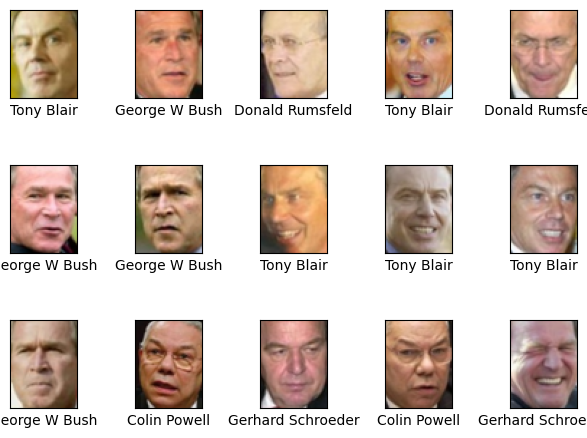

In [8]:
# Check by Plotted Images
# Generate random 15 images
rand_labels = [np.random.randint(0, len(faces.data)) for x in range(0,15)]

fig, ax = plt.subplots(3, 5)
fig.tight_layout()
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[rand_labels[i]], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[rand_labels[i]]])

# Preprocessing

In [9]:
'''
    Pada bagian ini Anda diperbolehkan untuk melakukan proses pra pengolahan data (preprocessing) sesuai dengan kebutuhan. Pra pengolahan data dapat berupa,

    1. Standardisasi nilai fitur ataupun label
    2. Penyesuaian ukuran gambar
    3. Perubahan colorspace gambar
    4. dsb
'''
# Importing the StandardScaler for feature scaling
from sklearn.preprocessing import StandardScaler

# Initializing the StandardScaler object to normalize features (mean = 0, std dev = 1)
scaler = StandardScaler()

# Features Extraction

In [10]:
'''
    Pada bagian ini, lakukan proses ekstraksi fitur yang diminta, yaitu histogram tiap channel.
    Terdapat banyak cara untuk melakukan ekstraksi fitur histrogram.

    Hints:
        Salah satu cara untuk melakukan ekstraksi fitur histrogram adalah,
        Anda dapat menggunakan fungsi np.histrogram dari library numpy
'''
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler  # For feature scaling
from sklearn.model_selection import GridSearchCV  # For hyperparameter tuning


def generate_hist(data, bins_num=50, normalize=True, transform=None):
    """
    Extracts histogram features from RGB images with optional normalization and transformation.

    Args:
        data (numpy.ndarray): Array of RGB images.
        bins_num (int, optional): Number of bins for the histogram. Defaults to 50.
        normalize (bool, optional): Normalize histograms by their sum. Defaults to True.
        transform (callable, optional): Function to apply to the histogram features.
                                        Defaults to None.

    Returns:
        numpy.ndarray: Array of concatenated histogram features for all images.
    """
# Function Extract Histogram Features For Each Channel
import cv2

def generate_hist(data, bins_num=5):
    hist_data = []

    for i in data:
        h_red = np.histogram(i[0][..., 0].ravel(), bins=bins_num)[0]
        h_green = np.histogram(i[1][..., 1].ravel(), bins=bins_num)[0]
        h_blue = np.histogram(i[2][..., 2].ravel(), bins=bins_num)[0]

        h_concat = np.concatenate((h_red, h_green, h_blue), axis=0) # Concat in row basis

        hist_data.append(h_concat)

    return np.array(hist_data)

hist_features = generate_hist(faces.images, bins_num=50)
hist_features.shape


def generate_sift(data):
    """
    Extracts SIFT features from RGB images.

    Args:
        data (numpy.ndarray): Array of RGB images.

    Returns:
        numpy.ndarray: Array of flattened SIFT descriptors for each image.
    """
    sift = cv2.SIFT_create()
    sift_data = []

    for img in data:
        # Check if the image is empty
        if img is not None and img.size > 0:
            # Convert the image to grayscale
            if len(img.shape) == 3:  # If the image has 3 channels (color)
                gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            else:
                gray_img = img  # Already grayscale

            # Check if the converted image is valid for SIFT
            if gray_img is not None and gray_img.dtype == np.uint8:
                keypoints, descriptors = sift.detectAndCompute(gray_img, None)
                if descriptors is not None:
                    sift_data.append(descriptors.flatten())  # Flatten descriptors for uniform feature length
                else:
                    sift_data.append(np.zeros(128 * 100))  # Padding if no descriptors found
            else:
                sift_data.append(np.zeros(128 * 100))  # Padding if grayscale conversion fails
        else:
            sift_data.append(np.zeros(128 * 100))  # Padding if image is empty

    return np.array(sift_data)

# Extract SIFT features
sift_features = generate_sift(faces.images)
print("SIFT Features Shape:", sift_features.shape)

SIFT Features Shape: (1140, 12800)


# Build Model

In [11]:
'''
    Pada bagian ini lakukan proses pembuatan model,

    1. Pembuatan data training dan data testing
    2. Pembuatan objek model
    3. Proses fitting model
'''
# Importing the RandomForestClassifier from scikit-learn's ensemble module
from sklearn.ensemble import RandomForestClassifier

# Splitting the dataset into training and testing sets
# 'hist_features' is the feature matrix and 'faces.target' is the target variable
# test_size=0.2 means 20% of the data will be used for testing, 80% for training
# stratify ensures the target variable is evenly distributed in both train and test sets
X_train, X_test, y_train, y_test = train_test_split(hist_features, faces.target, test_size=0.2, random_state=42, stratify=faces.target)

# Fitting the scaler to the training data and transforming it (important for some models like SVM)
X_train_rf = scaler.fit_transform(X_train)

# Scaling the test data using the same scaler fitted on the training data
X_test_rf = scaler.transform(X_test)

# Initializing and training the Support Vector Classifier (SVC) without scaling (could affect performance)
model1 = SVC()
model1.fit(X_train, y_train)

# Importing the RandomForestClassifier again (not necessary, already imported)
from sklearn.ensemble import RandomForestClassifier

# Initializing a RandomForestClassifier with 50 decision trees (n_estimators=50)
model2 = RandomForestClassifier(n_estimators=50, random_state=42)

# Fitting the Random Forest model to the scaled training data (better performance with scaling)
model2.fit(X_train_rf, y_train)

RandomForestClassifier(n_estimators=50, random_state=42)

# Evaluation

In [13]:
'''
    Pada bagian ini, lakukan evaluasi terhadap data training dan data testing
    dengan menggunakan metric akurasi dan juga classfication report

    Hints:
        Anda dapat menggunakan referensi Jobseet 4 Percobaan 5
'''
# Evaluation
# Eval on Training
y_train_predict1 = model1.predict(X_train)
acc_train = accuracy_score(y_train, y_train_predict1)

# Eval on Test
y_test_predict1 = model1.predict(X_test)
acc_test = accuracy_score(y_test, y_test_predict1)

# Print
print(f'Accuracy of SVC: {acc_test:.2%}')

# Eval Classification Report
print(classification_report(y_test, y_test_predict1, target_names=faces.target_names))


# Evaluation
# Eval on Training
y_train_predict2 = model2.predict(X_train)
acc_train2 = accuracy_score(y_train, y_train_predict2)

# Eval on Test
y_test_predict2 = model2.predict(X_test)
acc_test2 = accuracy_score(y_test, y_test_predict2)

# Print
print(f'Accuracy of Ramdom Forest Classifier: {acc_test2:.2%}')

# Eval Classification Report
print(classification_report(y_test, y_test_predict2, target_names=faces.target_names))

Accuracy of SVC: 48.68%
                   precision    recall  f1-score   support

     Colin Powell       0.64      0.15      0.24        47
  Donald Rumsfeld       0.00      0.00      0.00        24
    George W Bush       0.48      0.98      0.64       106
Gerhard Schroeder       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        29

         accuracy                           0.49       228
        macro avg       0.22      0.23      0.18       228
     weighted avg       0.35      0.49      0.35       228

Accuracy of Ramdom Forest Classifier: 47.81%
                   precision    recall  f1-score   support

     Colin Powell       0.33      0.15      0.21        47
  Donald Rumsfeld       0.00      0.00      0.00        24
    George W Bush       0.50      0.96      0.66       106
Gerhard Schroeder       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        29

         accuracy                        

Text(113.92222222222219, 0.5, 'predicted label')

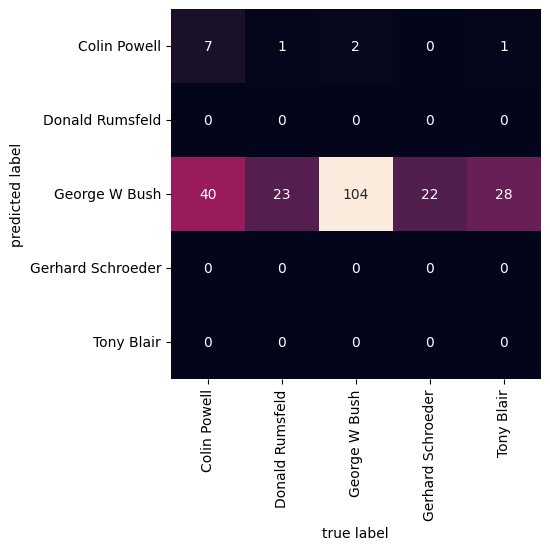

In [15]:
# Eval Confusion Matrix
# This is too large, we may not want it
mat = confusion_matrix(y_test, y_test_predict1)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')

                   precision    recall  f1-score   support

     Colin Powell       0.00      0.00      0.00        47
  Donald Rumsfeld       0.00      0.00      0.00        24
    George W Bush       0.46      1.00      0.63       106
Gerhard Schroeder       0.00      0.00      0.00        22
       Tony Blair       0.00      0.00      0.00        29

         accuracy                           0.46       228
        macro avg       0.09      0.20      0.13       228
     weighted avg       0.22      0.46      0.30       228



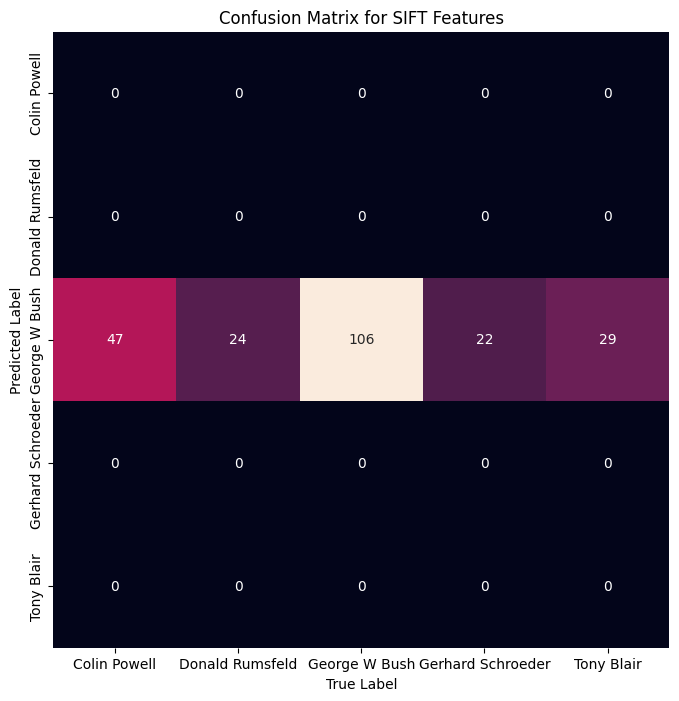

In [16]:
# Step 1: Split the dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(faces.images, faces.target, test_size=0.2, random_state=42, stratify=faces.target)

# Step 2: Extract SIFT features from training and testing images
sift_train_features = generate_sift(X_train)
sift_test_features = generate_sift(X_test)

# Step 3: Train a classifier on SIFT features
model = SVC()  # You can also use other classifiers
model.fit(sift_train_features, y_train)

# Step 4: Make predictions
y_test_predict = model.predict(sift_test_features)

# Step 5: Create confusion matrix
mat = confusion_matrix(y_test, y_test_predict)

classification_report = classification_report(y_test, y_test_predict, target_names=faces.target_names)
print(classification_report)

# Step 6: Visualize the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('True Label')
plt.ylabel('Predicted Label')
plt.title('Confusion Matrix for SIFT Features')
plt.show()